# 階層ベイズモデルで2018年のイングランドのプレミアムリーグを予想する

- 潜在的なパラメータ、つまりチームの「強さ」を測ることで、どこのチームが優勝候補かを知りたいと考えています。
- 利用するデータは、得点（ホームとアウェイ）と結果です。
- Teamの強さを正確に測定しているものでなく、あくまで「得点の強さ」だけに基づいています。

- 階層ベイズモデルは、この強さをモデル化するための優れたアプローチと考えられます。
- というのも、ゴールはそれだけ起こる確率が低いものと想定され、ポアソン分布がふさわしいと考えられるからです。
- ゴールは、起こる確率が常にランダムでありながら、単位時間あたり平均 λ回起こるようなランダムな事象が，単位時間に k回起きる確率と考えられ、この確率分布自体がポアソン分布であると言えます。

- 答えは、一つではなく、それぞれのチームの優勝候補の可能性や分布という形で得たい


In [17]:
import os
import math
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import StrMethodFormatter

from IPython.display import Image, HTML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.5


# Import Dataset from wikipedia
(https://en.wikipedia.org/wiki/2013–14_Premier_League)

In [3]:
result = pd.read_csv('combined.csv')
result.head(100)

,combined,ARS,BOU,BHA,BUR,CHE,CRY,EVE,HUD,LEI,LIV,MCI,MUN,NEW,SOU,TOT,WAT,WHU
0,Arsenal,—,3–0,2–0,5–0,2–2,4–1,2–0,5–0,4–3,3–3,0–2,1–3,1–0,3–2,2–0,2–0,3–1
1,Bournemouth,2–1,—,2–1,1–2,0–1,2–1,2–2,4–0,4–2,0–4,1–2,0–2,2–2,1–1,1–4,0–2,3–3
2,Brighton & Hove Albion,2–1,2–2,—,0–0,0–4,0–0,1–1,1–1,0–2,1–5,0–2,3–2,1–0,1–1,1–2,1–0,1–0
3,Burnley,0–1,4–0,0–0,—,1–2,1–0,2–1,1–1,2–1,1–2,1–1,0–2,1–0,1–1,0–3,1–3,1–1
4,Chelsea,3–2,2–0,2–0,2–3,—,2–1,2–0,1–1,0–0,1–1,0–1,1–0,3–1,1–0,1–3,4–2,1–1
5,Crystal Palace,2–3,2–2,3–2,1–0,2–1,—,2–2,0–3,5–0,0–2,0–0,2–3,0–0,0–2,0–1,2–1,2–2
6,Everton,2–5,2–1,2–0,0–1,0–0,3–1,—,1–1,2–1,0–0,1–3,0–2,1–0,2–1,0–3,3–2,1–3
7,Huddersfield Town,0–1,4–1,2–0,0–0,0–3,0–1,0–2,—,1–1,0–3,1–2,2–1,1–0,0–0,0–2,1–0,1–4
8,Leicester City,3–1,1–1,2–0,1–0,1–2,0–3,1–2,3–1,—,1–2,0–2,2–2,1–2,0–0,2–1,2–0,0–2
9,Liverpool,4–0,3–0,1–0,1–1,1–1,1–0,1–1,3–0,2–1,—,0–0,0–0,2–0,3–0,2–2,5–0,4–0


## 結果データを加工します（１行に全ての試合結果をまとめる）

In [4]:
#result=pd.read_csv('result.csv', sep='\t', index_col=0)
result=pd.read_csv('combined.csv', index_col=0)

In [5]:
result.columns

Index(['ARS', 'BOU', 'BHA', 'BUR', 'CHE', 'CRY', 'EVE', 'HUD', 'LEI', 'LIV',
       'MCI', 'MUN', 'NEW', 'SOU', 'TOT', 'WAT', 'WHU'],
      dtype='object')

In [6]:
result.index

Index(['Arsenal', 'Bournemouth', 'Brighton & Hove Albion', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Huddersfield Town',
       'Leicester City', 'Liverpool', 'Manchester City', 'Manchester United',
       'Newcastle United', 'Southampton', 'Tottenham Hotspur', 'Watford',
       'West Ham United'],
      dtype='object', name='combined')

In [7]:
result.index=result.columns

In [8]:
rows = []
for i in result.index:
    for c in result.columns:
        if i == c: continue
        score = result.ix[i, c]
        rows.append([i, c, score])
result_df = pd.DataFrame(rows, columns = ['home', 'away', 'score'])
result_df.head()

,home,away,score
0,ARS,BOU,3–0
1,ARS,BHA,2–0
2,ARS,BUR,5–0
3,ARS,CHE,2–2
4,ARS,CRY,4–1


In [9]:
df = pd.concat([result_df, result_df['score'].str.split('–', expand=True)], axis=1).drop('score', axis=1)
df.rename(columns={0: 'home_score', 1: 'away_score'}, inplace=True)
df.head()

,home,away,home_score,away_score
0,ARS,BOU,3,0
1,ARS,BHA,2,0
2,ARS,BUR,5,0
3,ARS,CHE,2,2
4,ARS,CRY,4,1


In [10]:
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

,team,i
0,ARS,0
1,BOU,1
2,BHA,2
3,BUR,3
4,CHE,4


In [11]:
# その他のvalueなどを変数化しておく

In [12]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head(30)

,home,away,home_score,away_score,i_home,i_away
0,ARS,BOU,3,0,0,1
1,ARS,BHA,2,0,0,2
2,ARS,BUR,5,0,0,3
3,ARS,CHE,2,2,0,4
4,ARS,CRY,4,1,0,5
5,ARS,EVE,2,0,0,6
6,ARS,HUD,5,0,0,7
7,ARS,LEI,4,3,0,8
8,ARS,LIV,3,3,0,9
9,ARS,MCI,0,2,0,10


## その他のvalueなどを変数化しておく

In [13]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.unique())
num_games = len(home_team)

In [14]:
teams = df.home.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams

,team
0,ARS
1,BOU
2,BHA
3,BUR
4,CHE
5,CRY
6,EVE
7,HUD
8,LEI
9,LIV


# モデル構築

サッカーのゴール数はポアソン分布に従う。

ポアソン分布とは、[単位時間あたり平均 λ回起こるようなランダムな事象が，単位時間に k回起きる確率]


アマゾンでの事例：とある商品は最初の10日で3個しか売れませんでした。ですが、本来は２ヶ月（60日）で60個売れる算段を立てて在庫（２ヶ月分の在庫）を調達していたのです。つまり、1日で1個です。

このペースが今後も続きそうだと仮定した場合、次の1日で1個売れる確率はどれくらいあるか。個数が0個の確率は約5%、1個の確率は約15%、2個の確率は約22%…10個も売れる確率は約0.1%です。これを用いると売れない商品がどういう商品かわかるので、そのような商品ばかりを集めたセンターを作りました。

他にも、「ある田舎のお店の来店客数」、「ある交差点で1時間に起こる事故の件数」、「1ページの文章を入力する時に打ち間違いを起こす回数、、「馬に蹴られて死亡する回数」など、発生する確率が低く、かつそれが偶然に発生する事象が対象になります。このことから、「少数の法則」とも呼ばれます。


事象そのものが起こる確率は常にランダムでありながらある期間において一定であるほど、ポアソン分布は有効だと考えられています。

サッカーのゴールはそれだけ起こる確率が常にランダムでありながら、単位時間あたり平均 λ回起こるようなランダムな事象が，単位時間に k回起きる確率はあると考えられます。

ポアソン分布のパラメータであるλをいかに推定するかという問題になるわけですが、以下を前提にしています。
  - 各チームの攻撃力・守備力は前年の攻撃力・守備力を平均とする正規分布に従う
  - 各チームの攻撃力・守備力のばらつきはチームごとに定義され、年間で一定である
  - 各チームの攻撃力・守備力はシーズン中の変化しない

## 数式は以下の論文より
http://discovery.ucl.ac.uk/16040/1/16040.pdf

## PyMC3
PyMC3でモデルを構築し、グローバルパラメータとチーム固有のパラメータと尤度関数を指定します

In [15]:
import theano.tensor as tt
import theano

In [18]:
with pm.Model() as model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept')

    # team固有
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=num_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data:尤度関数
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [defs_star, atts_star, intercept, sd_def, sd_att, home]
Sampling 10 chains: 100%|██████████| 20000/20000 [00:23<00:00, 858.13draws/s] 


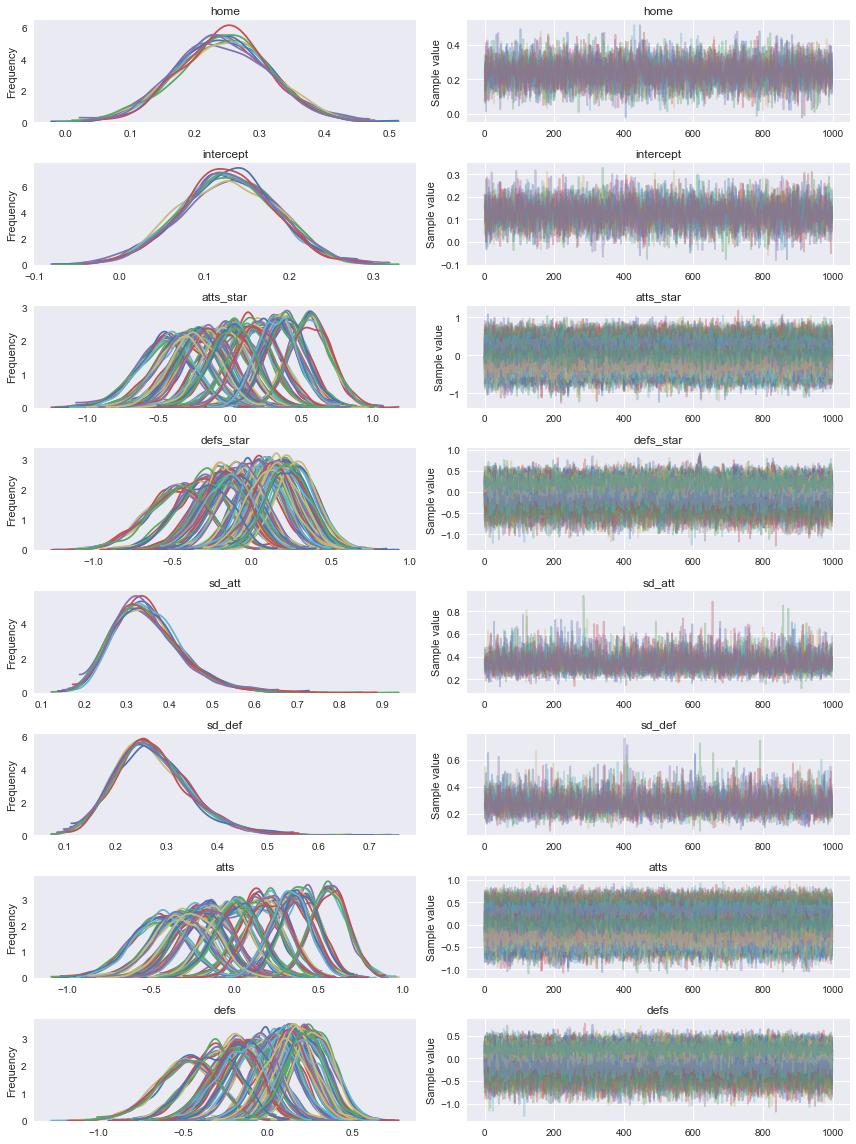

In [19]:
with model:
    trace = pm.sample(1000, tune=1000, cores=10)
    pm.traceplot(trace)

In [20]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

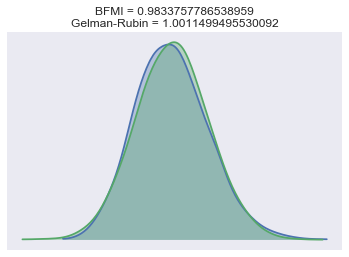

In [21]:
(pm.energyplot(trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

## モデルはよく収束し、Gelman-Rubinの統計量は良い感じに見えました
モデルが正しい属性を返すことを確認するために、いくつかの統計を見てみましょう。いくつかのチームは他のチームより強くなっていることがわかります。

In [22]:
pm.stats.hpd(trace['atts'])

array([[ 0.08552497,  0.56955762],
       [-0.31491797,  0.22714938],
       [-0.78333546, -0.12501156],
       [-0.50081375,  0.072955  ],
       [-0.12489139,  0.37667168],
       [-0.44411847,  0.11021394],
       [-0.44596473,  0.11935706],
       [-0.65039639, -0.0334936 ],
       [-0.25774906,  0.27246832],
       [ 0.16639227,  0.61646134],
       [ 0.33942889,  0.78657477],
       [-0.04736923,  0.44039704],
       [-0.64441811, -0.02319665],
       [-0.57193303,  0.02548469],
       [ 0.09013389,  0.56099968],
       [-0.25249316,  0.27664836],
       [-0.27386217,  0.27731149]])

In [23]:
pm.stats.quantiles(trace['atts'])[50]

array([ 0.33691411, -0.04255413, -0.45716732, -0.21273258,  0.13433479,
       -0.15777191, -0.15658735, -0.34318681,  0.01348562,  0.39168872,
        0.5606526 ,  0.20327448, -0.32932785, -0.24966887,  0.32888887,
        0.01320277,  0.01518898])

# 学習結果

上記から、攻撃力と防御力の異なる分布を理解することができました。これらは確率的な見積です。

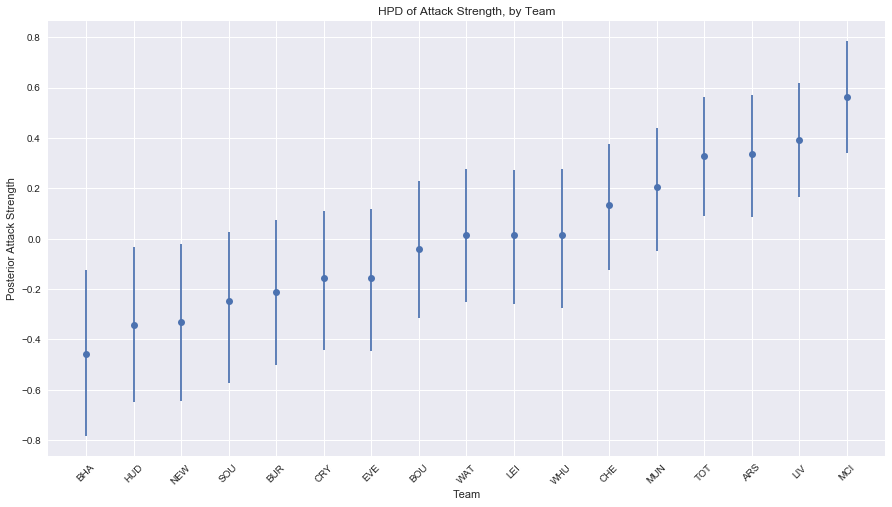

In [24]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['atts'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(15,8))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

推定値のいくつかの不確実性の定量化を行うことができます。


攻撃力に関して：

- それぞれのチームの攻撃力に対するベイジアンの信頼区間を以下に表します。

- LIV, MCIなどが攻撃力が高いことになります。これは、近年これらのチームが勝利して以来期待していることです。

- NORは他の誰よりも後ろにあります。



GridSpec(1, 2, width_ratios=[3, 1])

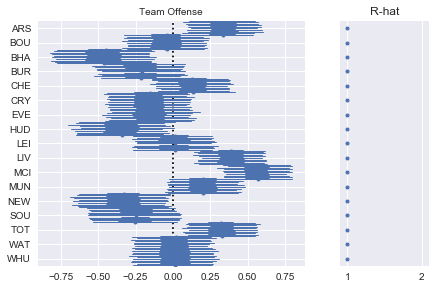

In [25]:
labels = teams.team.values
pm.forestplot(trace, varnames=['atts'], ylabels=labels, main="Team Offense")

防御力に関して：

- CHEのような優秀なチームは、強い防御力が見られます。
-  強力なチームは攻撃に対して強力なポジティブな効果をもたらし、防御には強い悪影響を及ぼすことが期待されます

GridSpec(1, 2, width_ratios=[3, 1])

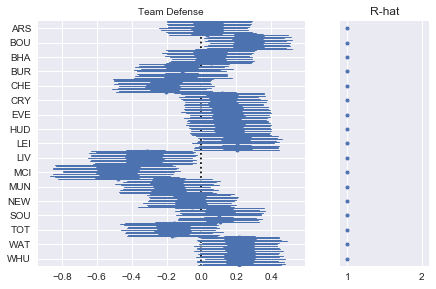

In [26]:
pm.forestplot(trace, varnames=['defs'], ylabels=labels, main="Team Defense")

## 防御効果について寄り道をする

In [27]:
teams

,team
0,ARS
1,BOU
2,BHA
3,BUR
4,CHE
5,CRY
6,EVE
7,HUD
8,LEI
9,LIV


## 防御力注目はMCI（def_10）

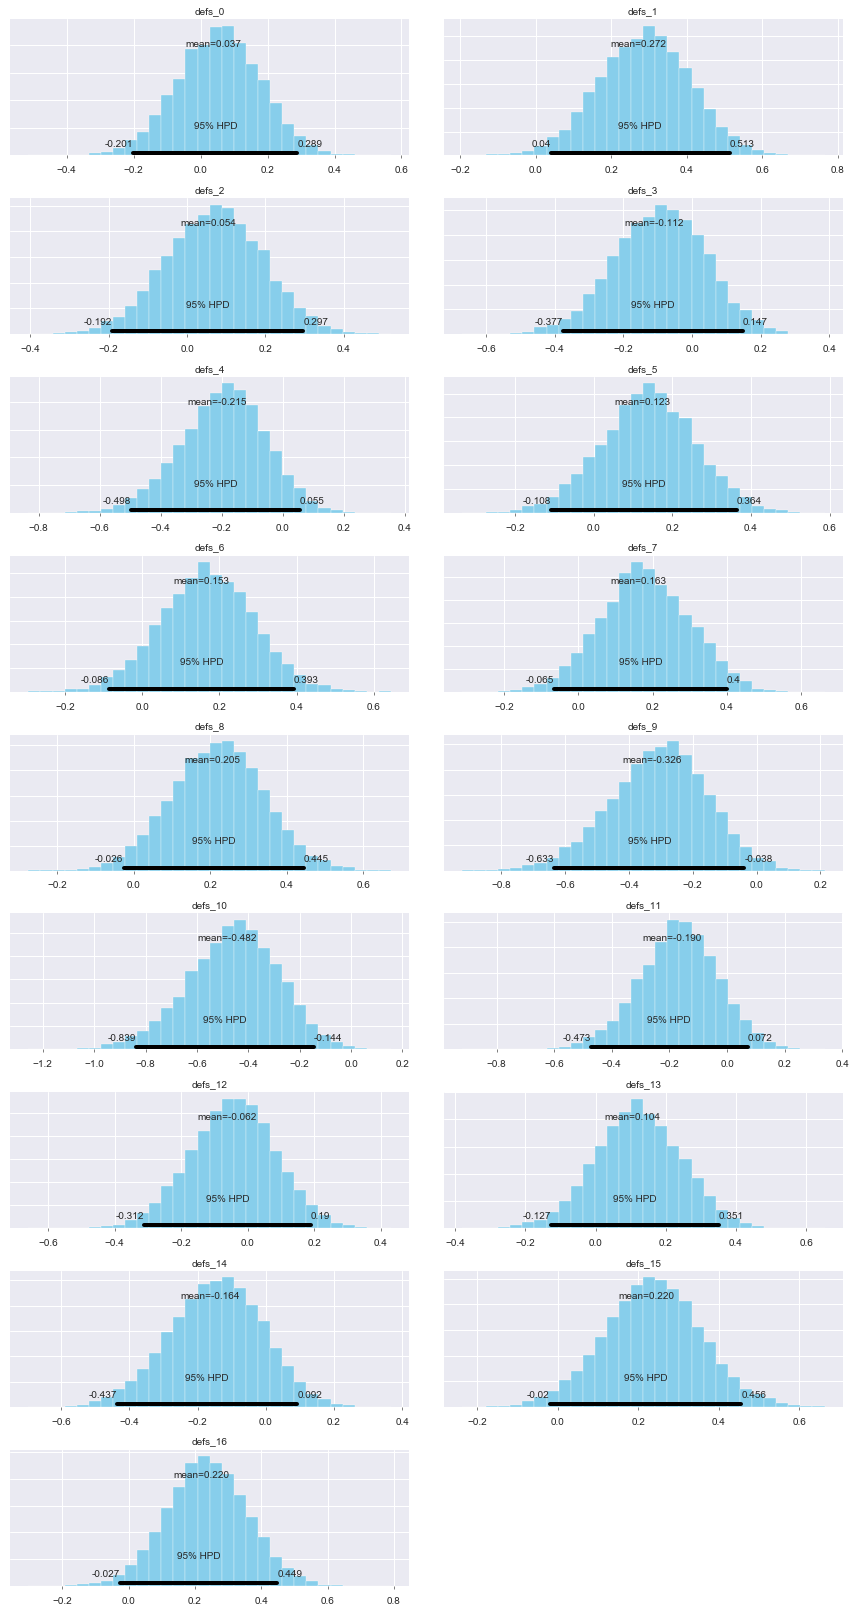

In [29]:
pm.plot_posterior(trace, varnames=['defs']);

# 予測（１０００シーズン）

In [30]:
with model:
    pp_trace = pm.sample_ppc(trace)

100%|██████████| 1000/1000 [00:01<00:00, 774.32it/s]


In [31]:
pp_trace['home_points']

array([[3, 2, 4, ..., 0, 0, 0],
       [2, 4, 0, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 0, 3],
       ...,
       [3, 3, 3, ..., 0, 3, 1],
       [2, 6, 0, ..., 1, 4, 1],
       [3, 2, 2, ..., 2, 4, 2]])

In [32]:
home_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * home_won
        for i, home_won in enumerate(pp_trace['home_points'] > pp_trace['away_points'])
})
#home_sim_df.insert(0, 'team', df['home_team'])
home_sim_df.insert(0, 'team', df['home'])

away_sim_df = pd.DataFrame({
    'sim_points_{}'.format(i): 3 * away_won
        for i, away_won in enumerate(pp_trace['home_points'] < pp_trace['away_points'])
})
#away_sim_df.insert(0, 'team', df['away_team'])
away_sim_df.insert(0, 'team', df['away'])

In [33]:
home_sim_df

,team,sim_points_0,sim_points_1,sim_points_10,sim_points_100,sim_points_101,sim_points_102,sim_points_103,sim_points_104,sim_points_105,...,sim_points_990,sim_points_991,sim_points_992,sim_points_993,sim_points_994,sim_points_995,sim_points_996,sim_points_997,sim_points_998,sim_points_999
0,ARS,0,3,3,0,3,3,3,3,3,...,3,3,3,0,0,3,0,3,3,3
1,ARS,3,3,3,0,0,3,3,3,3,...,3,0,0,0,3,3,3,3,3,3
2,ARS,3,0,0,3,3,0,0,0,3,...,3,0,0,3,3,3,3,3,0,3
3,ARS,3,3,0,3,0,3,3,3,3,...,3,3,3,3,0,3,0,3,3,0
4,ARS,3,3,3,3,0,3,3,3,0,...,3,3,3,0,0,3,0,3,3,3
5,ARS,0,3,3,3,0,3,0,3,3,...,3,3,3,0,3,0,3,3,0,3
6,ARS,3,3,0,3,0,0,3,3,3,...,3,0,3,0,3,3,3,0,3,3
7,ARS,0,3,3,3,0,3,3,3,0,...,0,3,3,0,0,3,0,3,3,0
8,ARS,3,3,0,3,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ARS,0,0,0,0,0,0,0,0,3,...,0,3,0,3,0,3,0,0,0,0


In [34]:
home_sim_a=home_sim_df.groupby('team').sum()
print(home_sim_a)

      sim_points_0  sim_points_1  sim_points_10  sim_points_100  \
team                                                              
ARS             30            39             27              24   
BHA             15            21             15              15   
BOU             21            18             12              21   
BUR             18            33             21              24   
CHE             12            27             18              36   
CRY             15             9             15              15   
EVE             12            12             21              18   
HUD             15            15             21              12   
LEI             18            21             18              21   
LIV             27            39             27              30   
MCI             36            45             24              42   
MUN             18            30             21              27   
NEW             24            18             15              1

In [35]:
away_sim_a=away_sim_df.groupby('team').sum()
print(away_sim_a)

      sim_points_0  sim_points_1  sim_points_10  sim_points_100  \
team                                                              
ARS             12            18             21              30   
BHA              6             6             12               9   
BOU             12             6             21               9   
BUR             15            18              6               9   
CHE             27            21             21               9   
CRY             24             9              9               6   
EVE              6             3              6               6   
HUD              3             6              9               3   
LEI             12            12             18              15   
LIV             18            15             33              21   
MCI             33            21             27              36   
MUN             18            27             15              21   
NEW              9            12              9               

In [36]:
ha_added=home_sim_a.add(away_sim_a)
ha_added

,sim_points_0,sim_points_1,sim_points_10,sim_points_100,sim_points_101,sim_points_102,sim_points_103,sim_points_104,sim_points_105,sim_points_106,...,sim_points_990,sim_points_991,sim_points_992,sim_points_993,sim_points_994,sim_points_995,sim_points_996,sim_points_997,sim_points_998,sim_points_999
team,,,,,,,,,,,,,,,,,,,,,
ARS,42,57,48,54,39,42,48,51,57,45,...,51,51,57,42,36,60,45,69,45,39
BHA,21,27,27,24,42,12,15,21,24,30,...,15,15,18,39,30,30,39,18,21,24
BOU,33,24,33,30,33,36,30,36,45,27,...,12,18,30,21,45,27,36,27,21,27
BUR,33,51,27,33,33,33,27,30,24,39,...,39,33,36,27,39,36,27,30,30,27
CHE,39,48,39,45,54,57,36,57,45,51,...,39,54,42,30,54,54,54,39,48,57
CRY,39,18,24,21,33,30,21,21,21,30,...,21,24,30,39,36,24,33,21,30,21
EVE,18,15,27,24,21,51,24,33,24,39,...,24,33,30,24,45,42,24,39,18,33
HUD,18,21,30,15,21,21,36,27,42,21,...,15,12,30,15,12,27,9,24,15,30
LEI,30,33,36,36,30,30,24,36,30,30,...,36,39,39,39,36,36,21,24,39,33


In [37]:
ranked_ha=ha_added.rank(ascending=False, method='min', axis=0)
ranked_ha

,sim_points_0,sim_points_1,sim_points_10,sim_points_100,sim_points_101,sim_points_102,sim_points_103,sim_points_104,sim_points_105,sim_points_106,...,sim_points_990,sim_points_991,sim_points_992,sim_points_993,sim_points_994,sim_points_995,sim_points_996,sim_points_997,sim_points_998,sim_points_999
team,,,,,,,,,,,,,,,,,,,,,
ARS,5.0,3.0,4.0,2.0,6.0,7.0,3.0,2.0,4.0,6.0,...,5.0,5.0,2.0,4.0,8.0,2.0,6.0,2.0,6.0,6.0
BHA,13.0,12.0,12.0,11.0,5.0,17.0,17.0,15.0,11.0,10.0,...,15.0,15.0,16.0,5.0,12.0,10.0,7.0,17.0,14.0,14.0
BOU,9.0,13.0,9.0,10.0,9.0,8.0,10.0,7.0,5.0,14.0,...,17.0,13.0,11.0,15.0,5.0,12.0,9.0,12.0,14.0,11.0
BUR,9.0,6.0,12.0,8.0,9.0,10.0,12.0,13.0,11.0,7.0,...,7.0,9.0,9.0,12.0,7.0,7.0,11.0,11.0,9.0,11.0
CHE,6.0,7.0,5.0,6.0,2.0,2.0,7.0,1.0,5.0,2.0,...,7.0,3.0,6.0,11.0,4.0,3.0,4.0,5.0,5.0,4.0
CRY,6.0,16.0,15.0,15.0,9.0,11.0,16.0,15.0,16.0,10.0,...,14.0,12.0,11.0,5.0,8.0,15.0,10.0,16.0,9.0,16.0
EVE,14.0,17.0,12.0,11.0,16.0,5.0,13.0,11.0,11.0,7.0,...,12.0,9.0,11.0,14.0,5.0,6.0,13.0,5.0,16.0,7.0
HUD,14.0,14.0,11.0,17.0,16.0,15.0,7.0,14.0,7.0,16.0,...,15.0,16.0,11.0,17.0,16.0,12.0,17.0,14.0,17.0,10.0
LEI,12.0,9.0,6.0,7.0,13.0,11.0,13.0,7.0,10.0,10.0,...,9.0,6.0,7.0,5.0,8.0,7.0,15.0,14.0,7.0,7.0


In [38]:
ranked_ha_reser_index=ranked_ha.reset_index()
ranked_ha_reser_index

,team,sim_points_0,sim_points_1,sim_points_10,sim_points_100,sim_points_101,sim_points_102,sim_points_103,sim_points_104,sim_points_105,...,sim_points_990,sim_points_991,sim_points_992,sim_points_993,sim_points_994,sim_points_995,sim_points_996,sim_points_997,sim_points_998,sim_points_999
0,ARS,5.0,3.0,4.0,2.0,6.0,7.0,3.0,2.0,4.0,...,5.0,5.0,2.0,4.0,8.0,2.0,6.0,2.0,6.0,6.0
1,BHA,13.0,12.0,12.0,11.0,5.0,17.0,17.0,15.0,11.0,...,15.0,15.0,16.0,5.0,12.0,10.0,7.0,17.0,14.0,14.0
2,BOU,9.0,13.0,9.0,10.0,9.0,8.0,10.0,7.0,5.0,...,17.0,13.0,11.0,15.0,5.0,12.0,9.0,12.0,14.0,11.0
3,BUR,9.0,6.0,12.0,8.0,9.0,10.0,12.0,13.0,11.0,...,7.0,9.0,9.0,12.0,7.0,7.0,11.0,11.0,9.0,11.0
4,CHE,6.0,7.0,5.0,6.0,2.0,2.0,7.0,1.0,5.0,...,7.0,3.0,6.0,11.0,4.0,3.0,4.0,5.0,5.0,4.0
5,CRY,6.0,16.0,15.0,15.0,9.0,11.0,16.0,15.0,16.0,...,14.0,12.0,11.0,5.0,8.0,15.0,10.0,16.0,9.0,16.0
6,EVE,14.0,17.0,12.0,11.0,16.0,5.0,13.0,11.0,11.0,...,12.0,9.0,11.0,14.0,5.0,6.0,13.0,5.0,16.0,7.0
7,HUD,14.0,14.0,11.0,17.0,16.0,15.0,7.0,14.0,7.0,...,15.0,16.0,11.0,17.0,16.0,12.0,17.0,14.0,17.0,10.0
8,LEI,12.0,9.0,6.0,7.0,13.0,11.0,13.0,7.0,10.0,...,9.0,6.0,7.0,5.0,8.0,7.0,15.0,14.0,7.0,7.0
9,LIV,4.0,5.0,1.0,3.0,2.0,3.0,6.0,7.0,1.0,...,3.0,2.0,4.0,2.0,3.0,5.0,5.0,4.0,2.0,3.0


In [39]:
ha=pd.melt(ranked_ha_reser_index, id_vars=['team'], value_name='rank')
ha

,team,variable,rank
0,ARS,sim_points_0,5.0
1,BHA,sim_points_0,13.0
2,BOU,sim_points_0,9.0
3,BUR,sim_points_0,9.0
4,CHE,sim_points_0,6.0
5,CRY,sim_points_0,6.0
6,EVE,sim_points_0,14.0
7,HUD,sim_points_0,14.0
8,LEI,sim_points_0,12.0
9,LIV,sim_points_0,4.0


In [40]:
sim_table=ha.groupby('team')['rank'].value_counts().unstack(level='rank').fillna(0).div(1000)
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0
team,,,,,,,,,,,,,,,,,
ARS,0.040,0.117,0.157,0.165,0.175,0.134,0.079,0.050,0.028,0.027,0.012,0.007,0.005,0.003,0.000,0.001,0.000
BHA,0.000,0.000,0.001,0.003,0.009,0.017,0.031,0.053,0.048,0.046,0.078,0.104,0.092,0.096,0.117,0.132,0.173
BOU,0.000,0.005,0.005,0.011,0.028,0.045,0.063,0.074,0.104,0.100,0.107,0.074,0.089,0.094,0.082,0.068,0.051
BUR,0.000,0.004,0.019,0.037,0.059,0.089,0.113,0.096,0.094,0.087,0.104,0.075,0.060,0.050,0.036,0.049,0.028
CHE,0.025,0.102,0.154,0.159,0.161,0.135,0.109,0.054,0.039,0.016,0.017,0.010,0.014,0.001,0.001,0.002,0.001
CRY,0.000,0.000,0.008,0.013,0.026,0.045,0.068,0.089,0.078,0.076,0.106,0.084,0.097,0.095,0.089,0.068,0.058
EVE,0.001,0.000,0.007,0.018,0.025,0.036,0.067,0.063,0.097,0.088,0.091,0.093,0.082,0.104,0.106,0.069,0.053
HUD,0.000,0.000,0.003,0.004,0.012,0.011,0.035,0.044,0.044,0.059,0.074,0.064,0.094,0.111,0.130,0.153,0.162
LEI,0.000,0.004,0.011,0.017,0.038,0.078,0.086,0.113,0.121,0.086,0.097,0.086,0.062,0.072,0.057,0.047,0.025


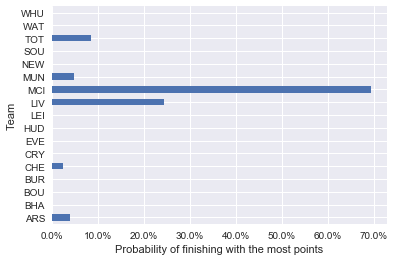

In [41]:
ax = sim_table.loc[:, 1.0].plot(kind='barh')

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'));
ax.set_xlabel("Probability of finishing with the most points");

ax.set_ylabel("Team");

# 結論

このモデルによれば、MCIは70％のポイントを獲得し、LIVは24％のポイントを獲得し、TOTは8％の確率で優勝候補となります。


# さらに引き分け戦になる試合について

In [42]:
hmpoints=pd.DataFrame(pp_trace['home_points'])
hmpoints.to_csv("hmpoints.csv")

In [43]:
awpoints=pd.DataFrame(pp_trace['away_points'])
awpoints.to_csv("awpoints.csv")